In [25]:
# Import packages
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim

import torch_geometric as tg
import torch_geometric.datasets as tgd

import random, os
import numpy as np
import sklearn as sk
import sklearn.metrics as sk_m

import matplotlib.pyplot as plt
import pyvis.network as pyv_n

import networkx as nx

### **Dependancies**
* python==3.12.9
* CUDA==12.1.0
* torch==2.6.0
* torch-geometric==2.6.1
* networkx==3.4.2
* scikit-learn==1.6.1
* tqdm==4.67.1

In [2]:
# Random seed setup
def set_seed(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

Name        : I Wayan Iswara Jay Junior\
StudentID   : 99061921A4

# **HOMEWORK 3: Hydronet Node Classification + Explainer**

### **Homework Description:**
In your homework, choose a dataset (one of available through torch_gemoetric.datasets [**DOCS**](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html).

Implement 2 or 3 various GNN classification architectures (try different types models) and explain the resulting model. 

* **Visualise the explanation.** 
* **Compare explanation of different architectures for the same node.**

## **0. Introduction**

To complete this homework, I want to train a Graph Neural Network to perform node classification of product categories in the Amazon-Computers dataset. This dataset is a homogeneous graph. The goal is to evaluate the effect of different graph architechtures on the inference explanation.

Dataset resources: 
* [**Amazon-Computers**](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#homogeneous-datasets)
* [**Source Paper**](https://arxiv.org/abs/1811.05868)


Graph: nodes represent products and edges connect co-purchased items. Features are bag-of-words encoded product descriptions, and classes correspond to product categories.

Objective: Predict the node class label for each nodes in a graph.

## **1. Dataset Import**

In [3]:
from torch_geometric.transforms import NormalizeFeatures

amazon_dataset = tgd.Amazon(root='homework_dataset/Amazon', name='Computers', transform=NormalizeFeatures())
amazon_graph = amazon_dataset[0]

# Print dataset statistics
print(f"Dataset: {amazon_dataset}")
print(f"Number of nodes: {amazon_graph.num_nodes}")
print(f"Number of edges: {amazon_graph.num_edges}")
print(f"Number of edge features: {amazon_graph.num_features}")
print(f"Number of classes: {amazon_dataset.num_classes}")

Dataset: AmazonComputers()
Number of nodes: 13752
Number of edges: 491722
Number of edge features: 767
Number of classes: 10


## **2. Data Splitting**

In [4]:
# Split amazon_graph into train-test set
if hasattr(amazon_graph, 'train_mask'):
    train_mask = amazon_graph.train_mask
    val_mask = amazon_graph.val_mask
    # test_mask = amazon_graph.test_mask
else:
    # Create random splits if the mask not available
    num_nodes = amazon_graph.num_nodes
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    node_permutation = torch.randperm(num_nodes) # Random sorting of node ID
    train_mask[node_permutation[:int(0.8 * num_nodes)]] = True
    val_mask[node_permutation[int(0.8 * num_nodes):int(0.95 * num_nodes)]] = True
    test_mask[node_permutation[int(0.95 * num_nodes):]] = True
    
    amazon_graph.train_mask = train_mask
    amazon_graph.val_mask = val_mask
    amazon_graph.test_mask = test_mask

print(f"Training nodes: {train_mask.sum().item()}")
print(f"Validation nodes: {val_mask.sum().item()}")
print(f"Test nodes: {test_mask.sum().item()}")

Training nodes: 11001
Validation nodes: 2063
Test nodes: 688


## **3. GNN Model**

Here we want to establish the GNN model architechture to train the data. 2 types of architechture, GraphSAGE with linear head and MLP head, are used.

In [18]:
class GraphSAGE_Classifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=64, classifier_type='linear', dropout=0.2):
        super(GraphSAGE_Classifier, self).__init__()
        self.classifier_type = classifier_type
        self.dropout = dropout
        
        # GNN Convolution layers
        self.conv1 = tg.nn.SAGEConv(input_dim, hidden_dim)
        self.conv2 = tg.nn.SAGEConv(hidden_dim, hidden_dim)
        
        # Classifier head layer
        if classifier_type == 'linear':
            self.head = nn.Linear(hidden_dim, num_classes)
        elif classifier_type == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim*2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim*2, hidden_dim*2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim*2, num_classes)
            )
        else:
            raise ValueError(f"Unknown head type: {classifier_type}")
    
    def forward(self, x, edge_index):
        x = nnF.relu(self.conv1(x, edge_index))
        x = nnF.relu(self.conv2(x, edge_index))
        x = nnF.dropout(x, p=self.dropout, training=self.training)
        logits = nnF.log_softmax(self.head(x), dim=1)
        return logits

## **4. Training & Evaluation**

In [6]:
# Train the model with train_mask
def train(model, data, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    
    output = model(data.x, data.edge_index)
    loss = loss_fn(output[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()

    return loss.item()
# Evaluate the model with val_mask
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask]
        acc = int(correct.sum()) / int(mask.sum())
    return acc

In [ ]:
# Train the model for a certain amount of epochs
def train_model(model, data, epochs=200, lr=0.01, weight_decay=5e-4, patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    
    best_val_acc = 0
    best_epoch = 0
    train_losses = []
    val_accs = []
    test_accs = []
    
    for epoch in range(1, epochs + 1):
        loss = train(model, data, optimizer, loss_fn)
        train_losses.append(loss)
        
        val_acc = evaluate(model, data, data.val_mask)
        val_accs.append(val_acc)
        
        test_acc = evaluate(model, data, data.test_mask)
        test_accs.append(test_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pt')
        
        # if epoch - best_epoch >= patience:
        #     print(f"Early stopping at epoch {epoch}")
        #     break
            
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Load best model
    # model.load_state_dict(torch.load('best_model.pt'))
    best_test_acc = evaluate(model, data, data.test_mask)
    # print(f"Best model at epoch {best_epoch}, Test Accuracy: {best_test_acc:.4f}")
    
    return {
        'train_losses': train_losses,
        'val_accs': val_accs,
        'test_accs': test_accs,
        # 'best_test_acc': best_test_acc,
        # 'best_epoch': best_epoch
    }

In [21]:
# GraphSAGE with linear head
sage_linear = GraphSAGE_Classifier(input_dim=amazon_dataset.num_node_features, num_classes=amazon_dataset.num_classes, 
                                   classifier_type='linear')
print("\nTraining GraphSAGE architechture with linear head...")
sage_linear_results = train_model(sage_linear, amazon_graph, epochs=100)

# GraphSAGE with MLP head
sage_mlp = GraphSAGE_Classifier(input_dim=amazon_dataset.num_node_features, num_classes=amazon_dataset.num_classes, 
                                classifier_type='mlp')
print("\nTraining GraphSAGE architechture with MLP head...")
sage_mlp_results = train_model(sage_mlp, amazon_graph, epochs=100)


Training GraphSAGE architechture with linear head...
Epoch: 010, Loss: 1.9514, Val Acc: 0.3781, Test Acc: 0.4026
Epoch: 020, Loss: 1.8495, Val Acc: 0.3781, Test Acc: 0.4026
Epoch: 030, Loss: 1.7581, Val Acc: 0.3781, Test Acc: 0.4026
Epoch: 040, Loss: 1.5570, Val Acc: 0.3781, Test Acc: 0.4026
Epoch: 050, Loss: 1.4517, Val Acc: 0.4610, Test Acc: 0.4840
Epoch: 060, Loss: 1.3752, Val Acc: 0.4838, Test Acc: 0.5131
Epoch: 070, Loss: 1.3069, Val Acc: 0.6049, Test Acc: 0.6381
Epoch: 080, Loss: 1.2276, Val Acc: 0.6524, Test Acc: 0.6817
Epoch: 090, Loss: 1.1060, Val Acc: 0.6772, Test Acc: 0.7180
Epoch: 100, Loss: 0.9615, Val Acc: 0.6927, Test Acc: 0.7180
Best model at epoch 100, Test Accuracy: 0.7180

Training GraphSAGE architechture with MLP head...
Epoch: 010, Loss: 1.9298, Val Acc: 0.3781, Test Acc: 0.4026
Epoch: 020, Loss: 1.8777, Val Acc: 0.3781, Test Acc: 0.4026
Epoch: 030, Loss: 1.6845, Val Acc: 0.3781, Test Acc: 0.4026
Epoch: 040, Loss: 1.4978, Val Acc: 0.4755, Test Acc: 0.5000
Epoch: 0

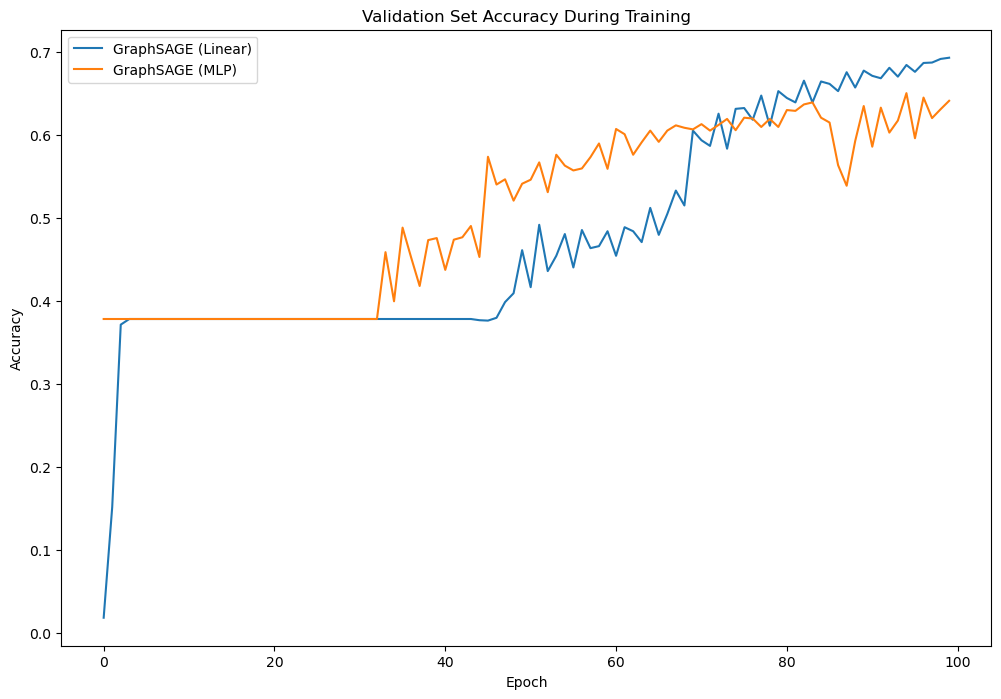


Final Test Accuracies:
GraphSAGE (Linear): 0.7180
GraphSAGE (MLP): 0.6453


In [23]:
# Collect results
results = {
    'GraphSAGE (Linear)': sage_linear_results,
    'GraphSAGE (MLP)': sage_mlp_results
}

# Plot training curves
plt.figure(figsize=(12, 8))
for name, res in results.items():
    plt.plot(res['val_accs'], label=name)
plt.title('Validation Set Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print Test Set accuracies
print("\nFinal Test Accuracies:")
for name, res in results.items():
    print(f"{name}: {res['best_test_acc']:.4f}")

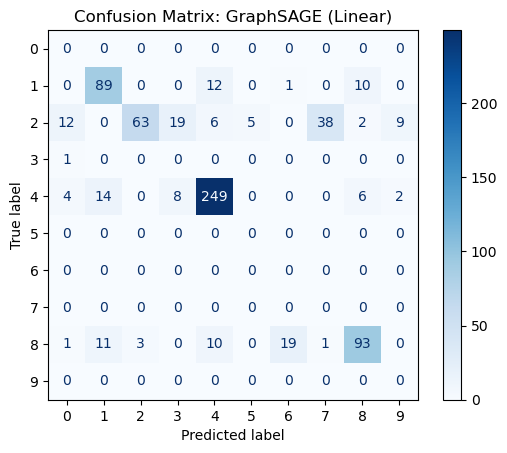

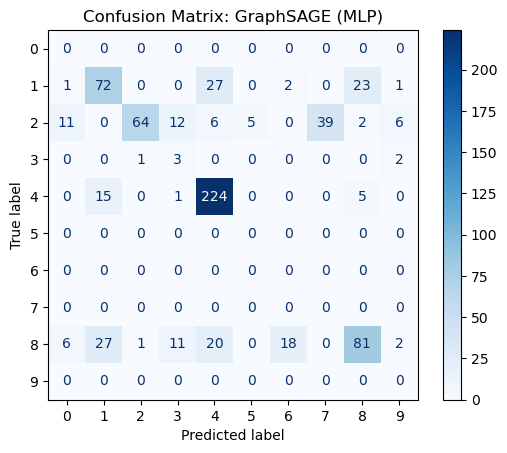

In [71]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
models = {
    'GraphSAGE (Linear)': sage_linear,
    'GraphSAGE (MLP)': sage_mlp
}
for name, model in models.items():
    model.eval()  # IMPORTANT!
    
    test_mask = amazon_graph.test_mask
    output = model(amazon_graph.x, amazon_graph.edge_index)
    predicted_class = torch.argmax(output[test_mask], axis=1)

    cm = sk_m.confusion_matrix(predicted_class, amazon_graph.y[test_mask])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

## **5. Explainer**

In [74]:
def explain_node(model, node_idx, data):
    explainer = tg.explain.Explainer(
        model=model,
        algorithm=tg.explain.GNNExplainer(epochs=50),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        )
    )
    explanation = explainer(data.x, data.edge_index, index=node_idx)
    return explainer, explanation

In [101]:

# Helper function to convert torch-geometric dataset to PyVis graph
from IPython.display import display, HTML

def tg_to_pyvisgraph(graph: tg.data.Data, colour_by_target: bool = True, max_nodes: int = 500) -> pyv_n.Network:
    pyv_graph = pyv_n.Network(directed=False, notebook=True, neighborhood_highlight=True, select_menu=True, filter_menu=True, cdn_resources='remote')
    y_colours = ["#888888", "#FF0000", "#00FF00", "#0000FF", "#00FFFF", "#FFFF00", "#FF00FF", "#880000", "#008800", "#000088"]
    nodes_exists = set()
    for n_id, node_attrs in enumerate(graph.x):
        n_id = int(n_id)
        label = int(graph.target[n_id]) if colour_by_target else 0
        pyv_graph.add_node(n_id=n_id, title=str(n_id), label=str(n_id), color=y_colours[label])
        nodes_exists.add(n_id)
        if n_id > max_nodes:
            break

    for u, v in zip(graph.edge_index[0], graph.edge_index[1]):
        u = int(u)
        v = int(v)
        if (u in nodes_exists) and (v in nodes_exists):
            pyv_graph.add_edge(u, v)

    return pyv_graph

In [77]:
amazon_graph.test_mask.nonzero(as_tuple=False)[0].item()

11

Explaining node 62 with true class 1


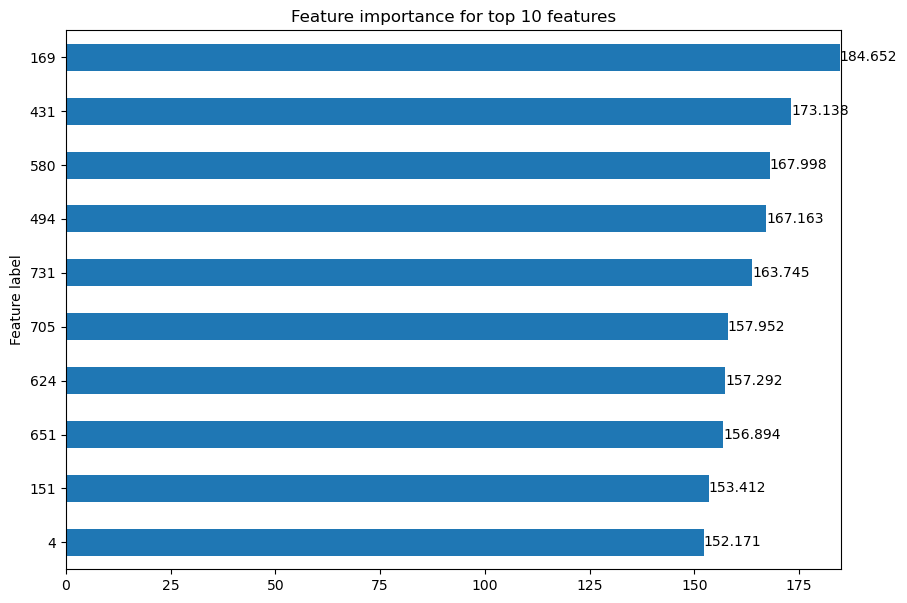

Positive fidelity :1.000
Negative fidelity :0.000
Unfaithfulness of the explanation: 0.184


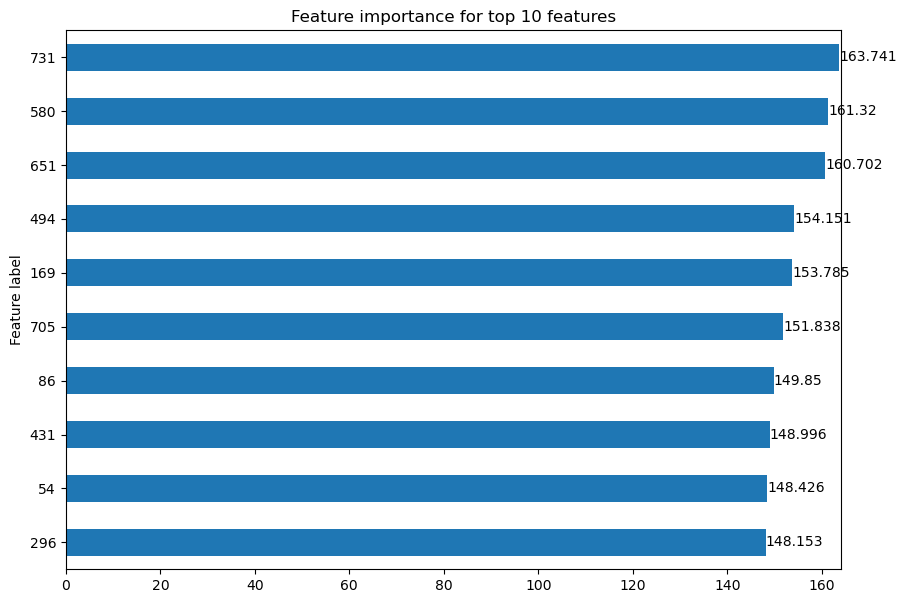

Positive fidelity :1.000
Negative fidelity :0.000
Unfaithfulness of the explanation: 0.121


In [102]:
# Select a node to explain (from test set)
test_nodes = torch.where(amazon_graph.test_mask)[0]
node_to_explain = test_nodes[5].item()  # Let's pick the 5th test node
print(f"Explaining node {node_to_explain} with true class {amazon_graph.y[node_to_explain].item()}")

models = {
    'GraphSAGE (Linear)': sage_linear,
    'GraphSAGE (MLP)': sage_mlp
}
for name, model in models.items():
    model.eval()  # <-- important!
    explainer, explanation = explain_node(model, node_to_explain, amazon_graph)
    explanation.visualize_feature_importance(top_k=10)
    
    # Visualize the important subgraph for the first test node classification
    subgraph = tg_to_pyvisgraph(explanation.get_explanation_subgraph(), max_nodes=300)
    subgraph.save_graph("homework3_"+name+"_explanation_subG_node11.html")  # Save it
    
    fidelity_positive, fidelity_negative = tg.explain.fidelity(explainer, explanation)
    print("Positive fidelity :{:.3f}".format(fidelity_positive))
    print("Negative fidelity :{:.3f}".format(fidelity_negative))
    # print("Characterisation score {:.3f}".format(tg.explain.characterization_score(fidelity_positive, fidelity_negative)))
    print("Unfaithfulness of the explanation: {:.3f}".format(tg.explain.unfaithfulness(explainer, explanation)))

### **Observations**

I used **GNNExplainer** to see the difference between the explainability of GraphSAGE architechture with linear v.s. MLP classification head. Judging from the model performance, linear head gives better test accuracy. Both architechture yield low overfitting towards the dataset used.


The explainer shows:

**1. Feature Importance**
- The linear head showed higher increase towards its top 3 most important features compared to a more even distribution of feature importance given by MLP head.

**2. Explanation Subgraph**
- The linear and MLP head showed similar subgraph in terms of neighborhood profile and neighborhood class labels, indicating classifier head effects on neighborhood is lesser than the convolution architechture.

**3. Fidelity & Unfaithfulness**
- Both models achieved **positive fidelity=1**, indicating that both models preserves most or all the evidence needed to retain the original prediction.
- **negative fidelity=0** implies that non-relevant parts of the input did not influence the predictions.
- The **MLP head variant had lower unfaithfulness**, suggesting that its explanations were **more faithful and complete**.